In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from datetime import timedelta
from datetime import datetime
import scipy.stats as stats

import requests as r
import pandas as pd
import seaborn as s
import numpy as np

import postgres
import gmaps
import json
import math

In [2]:
import importlib
importlib.reload(postgres.config)

<module 'config' from '/media/storage/College/S3/Github/DublinBus/Analytics/config.py'>

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import Data

### Bus Data

In [4]:
# data = postgres.query("SELECT * FROM combined WHERE lineid='145';", tunnel=True)
# data = pd.DataFrame(data)
data = pd.read_csv("stored_queries/combined145.csv")
data.head(2)

,dayofservice,tripid,lineid,direction,progrnumber,stopid,plannedDEP,plannedARR,actualDEP,actualARR,routeid
0,2018-01-01,5955476,145,1,1,4320,32400,32400,32370,32370,145_102
1,2018-01-01,5955476,145,1,2,1476,32504,32504,32461,32461,145_102


In [5]:
data.columns = ['dayofservice','tripid','lineid','direction','progrnumber','stopid','plannedDEP','plannedARR','actualDEP','actualARR','routeid']
data.head(2)
data.dtypes

,dayofservice,tripid,lineid,direction,progrnumber,stopid,plannedDEP,plannedARR,actualDEP,actualARR,routeid
0,2018-01-01,5955476,145,1,1,4320,32400,32400,32370,32370,145_102
1,2018-01-01,5955476,145,1,2,1476,32504,32504,32461,32461,145_102


dayofservice    object
tripid           int64
lineid           int64
direction        int64
progrnumber      int64
stopid           int64
plannedDEP       int64
plannedARR       int64
actualDEP        int64
actualARR        int64
routeid         object
dtype: object

In [6]:
data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])
data.lineid = data.lineid.astype('category')
data.routeid= data.routeid.astype('category')

In [7]:
data.sort_values(by=['dayofservice','lineid','tripid','direction','progrnumber'],inplace=True)

In [8]:
# data.to_csv("stored_queries/combined145.csv", index=False, chunksize=500000)

### Stop Information

In [9]:
stops = pd.read_csv("stop_information.csv")

In [10]:
cols = list(stops.columns)
cols[0] = 'ix'
stops.columns = cols
stops.drop(columns=cols[0], inplace=True)

stops.head()

,id,stopid,stop_name,lat,lng,irish_name,routes
0,4240,2,Parnell Square,53.352241,-6.263695,Cearnóg Parnell,"['38', '38A', '38B', '38D', '46A', '46E']"
1,4241,3,Parnell Square,53.352307,-6.263783,Cearnóg Parnell,"['120', '122']"
2,4242,4,Parnell Square,53.352567,-6.264166,Cearnóg Parnell,"['7', '7A', '7B', '7D', '9']"
3,4243,6,Parnell Square,53.352744,-6.264443,Cearnóg Parnell,"['4', '155']"
4,4244,7,Parnell Square,53.352836,-6.264562,Cearnóg Parnell,"['13', '140', '40', '40B', '40D']"


### Weather Data

In [11]:
weather = pd.read_csv("stored_queries/weather.csv")
weather.head()

,dayofservice,hour,icon,temperature,humidity,cloudCover,windSpeed,rain
0,2018-01-01,0,partly-cloudy-night,41.19,0.80,0.58,17.04,0.0
1,2018-01-01,1,partly-cloudy-night,41.70,0.79,0.75,21.59,0.1
2,2018-01-01,2,partly-cloudy-night,41.95,0.78,0.75,21.59,0.0
3,2018-01-01,3,partly-cloudy-night,42.42,0.82,0.58,19.60,0.0
4,2018-01-01,4,partly-cloudy-night,42.09,0.83,0.44,20.48,0.0


In [12]:
weather.count()

dayofservice    8751
hour            8751
icon            8751
temperature     8751
humidity        8751
cloudCover      8496
windSpeed       8745
rain            8751
dtype: int64

In [13]:
weather.icon = weather.icon.astype('category')
weather.dayofservice = pd.to_datetime(weather.dayofservice)

## Matching weather data to combined data

In [14]:
# merge on date and time. ( or convert weather time to seconds? )
# converting to time stamp allows for ignoring of past midnight issues. <-- go with convert seconds to datetime. 
weather.head(1)
data.head(1)

,dayofservice,hour,icon,temperature,humidity,cloudCover,windSpeed,rain
0,2018-01-01,0,partly-cloudy-night,41.19,0.8,0.58,17.04,0.0


,dayofservice,tripid,lineid,direction,progrnumber,stopid,plannedDEP,plannedARR,actualDEP,actualARR,routeid
0,2018-01-01,5955476,145,1,1,4320,32400,32400,32370,32370,145_102


In [15]:
# leavetimes data
data.plannedARR = data.dayofservice + pd.to_timedelta(data.plannedARR, unit = 'seconds') # in nanoseconds
data.plannedDEP = data.dayofservice + pd.to_timedelta(data.plannedDEP, unit = 'seconds') # in nanoseconds
data.actualARR = data.dayofservice + pd.to_timedelta(data.actualARR, unit = 'seconds') # in nanoseconds
data.actualDEP = data.dayofservice + pd.to_timedelta(data.actualDEP, unit = 'seconds') # in nanoseconds

# # weather data
weather.dayofservice = weather.dayofservice + pd.to_timedelta(weather.hour, unit='hour')

In [16]:
data.head()
weather.head()

,dayofservice,tripid,lineid,direction,progrnumber,stopid,plannedDEP,plannedARR,actualDEP,actualARR,routeid
0,2018-01-01,5955476,145,1,1,4320,2018-01-01 09:00:00,2018-01-01 09:00:00,2018-01-01 08:59:30,2018-01-01 08:59:30,145_102
1,2018-01-01,5955476,145,1,2,1476,2018-01-01 09:01:44,2018-01-01 09:01:44,2018-01-01 09:01:01,2018-01-01 09:01:01,145_102
2,2018-01-01,5955476,145,1,3,7453,2018-01-01 09:02:59,2018-01-01 09:02:59,2018-01-01 09:01:48,2018-01-01 09:01:48,145_102
3,2018-01-01,5955476,145,1,4,1478,2018-01-01 09:04:10,2018-01-01 09:04:10,2018-01-01 09:03:02,2018-01-01 09:02:52,145_102
4,2018-01-01,5955476,145,1,5,1479,2018-01-01 09:04:58,2018-01-01 09:04:58,2018-01-01 09:03:50,2018-01-01 09:03:50,145_102


,dayofservice,hour,icon,temperature,humidity,cloudCover,windSpeed,rain
0,2018-01-01 00:00:00,0,partly-cloudy-night,41.19,0.80,0.58,17.04,0.0
1,2018-01-01 01:00:00,1,partly-cloudy-night,41.70,0.79,0.75,21.59,0.1
2,2018-01-01 02:00:00,2,partly-cloudy-night,41.95,0.78,0.75,21.59,0.0
3,2018-01-01 03:00:00,3,partly-cloudy-night,42.42,0.82,0.58,19.60,0.0
4,2018-01-01 04:00:00,4,partly-cloudy-night,42.09,0.83,0.44,20.48,0.0


In [17]:
data.columns
weather.columns

Index(['dayofservice', 'tripid', 'lineid', 'direction', 'progrnumber',
       'stopid', 'plannedDEP', 'plannedARR', 'actualDEP', 'actualARR',
       'routeid'],
      dtype='object')

Index(['dayofservice', 'hour', 'icon', 'temperature', 'humidity', 'cloudCover',
       'windSpeed', 'rain'],
      dtype='object')

In [18]:
data['time_at_stop'] = data.actualDEP - data.actualARR
data['weather_merge_time'] = data.actualARR.dt.round('H') #  .dt is super useful. 
data.head()

,dayofservice,tripid,lineid,direction,progrnumber,stopid,plannedDEP,plannedARR,actualDEP,actualARR,routeid,time_at_stop,weather_merge_time
0,2018-01-01,5955476,145,1,1,4320,2018-01-01 09:00:00,2018-01-01 09:00:00,2018-01-01 08:59:30,2018-01-01 08:59:30,145_102,00:00:00,2018-01-01 09:00:00
1,2018-01-01,5955476,145,1,2,1476,2018-01-01 09:01:44,2018-01-01 09:01:44,2018-01-01 09:01:01,2018-01-01 09:01:01,145_102,00:00:00,2018-01-01 09:00:00
2,2018-01-01,5955476,145,1,3,7453,2018-01-01 09:02:59,2018-01-01 09:02:59,2018-01-01 09:01:48,2018-01-01 09:01:48,145_102,00:00:00,2018-01-01 09:00:00
3,2018-01-01,5955476,145,1,4,1478,2018-01-01 09:04:10,2018-01-01 09:04:10,2018-01-01 09:03:02,2018-01-01 09:02:52,145_102,00:00:10,2018-01-01 09:00:00
4,2018-01-01,5955476,145,1,5,1479,2018-01-01 09:04:58,2018-01-01 09:04:58,2018-01-01 09:03:50,2018-01-01 09:03:50,145_102,00:00:00,2018-01-01 09:00:00


In [20]:
weather['rkey'] = weather.dayofservice

In [21]:
combinedata = data.merge(weather[['icon','temperature','humidity','windSpeed','rain','rkey']], left_on='weather_merge_time', right_on='rkey', how='left')

In [22]:
combinedata.drop(columns=['rkey','lineid'], inplace=True); # drop lineid as all are 145

### Dropping na values

In [23]:
combinedata = combinedata.dropna() # drop na values. 
combinedata.dtypes

dayofservice           datetime64[ns]
tripid                          int64
direction                       int64
progrnumber                     int64
stopid                          int64
plannedDEP             datetime64[ns]
plannedARR             datetime64[ns]
actualDEP              datetime64[ns]
actualARR              datetime64[ns]
routeid                      category
time_at_stop          timedelta64[ns]
weather_merge_time     datetime64[ns]
icon                         category
temperature                   float64
humidity                      float64
windSpeed                     float64
rain                          float64
dtype: object

### Removing outliers

In [25]:
# combinedata.time_at_stop.astype(int).apply(lambda x: x*10**-9).hist(bins=1000) # hitogram of times spent at a stop. 
combinedata.time_at_stop = combinedata.time_at_stop.astype(int) / 10**9
combinedata.head()

,dayofservice,tripid,direction,progrnumber,stopid,plannedDEP,plannedARR,actualDEP,actualARR,routeid,time_at_stop,weather_merge_time,icon,temperature,humidity,windSpeed,rain
0,2018-01-01,5955476,1,1,4320,2018-01-01 09:00:00,2018-01-01 09:00:00,2018-01-01 08:59:30,2018-01-01 08:59:30,145_102,0.0,2018-01-01 09:00:00,partly-cloudy-day,41.19,0.81,12.91,0.0
1,2018-01-01,5955476,1,2,1476,2018-01-01 09:01:44,2018-01-01 09:01:44,2018-01-01 09:01:01,2018-01-01 09:01:01,145_102,0.0,2018-01-01 09:00:00,partly-cloudy-day,41.19,0.81,12.91,0.0
2,2018-01-01,5955476,1,3,7453,2018-01-01 09:02:59,2018-01-01 09:02:59,2018-01-01 09:01:48,2018-01-01 09:01:48,145_102,0.0,2018-01-01 09:00:00,partly-cloudy-day,41.19,0.81,12.91,0.0
3,2018-01-01,5955476,1,4,1478,2018-01-01 09:04:10,2018-01-01 09:04:10,2018-01-01 09:03:02,2018-01-01 09:02:52,145_102,10.0,2018-01-01 09:00:00,partly-cloudy-day,41.19,0.81,12.91,0.0
4,2018-01-01,5955476,1,5,1479,2018-01-01 09:04:58,2018-01-01 09:04:58,2018-01-01 09:03:50,2018-01-01 09:03:50,145_102,0.0,2018-01-01 09:00:00,partly-cloudy-day,41.19,0.81,12.91,0.0


count    4116135
mean          13
std           29
min            0
25%            0
50%           11
75%           18
max        19795
Name: time_at_stop, dtype: int64

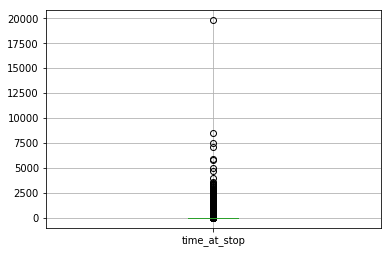

In [36]:
combinedata[combinedata['time_at_stop'] != 0].boxplot(column= ['time_at_stop'])
combinedata.time_at_stop.describe().astype(int)

Will use 3$\sigma$ as the threshold for outliers <br>
Note: This method can fail to detect outliers because the outliers increase the standard deviation.

In [ ]:
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

## Train Model

## Evaluate Model

## Changes